In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))])

batch_size = 100

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def lorentzian_curve(x, A, x0, gamma):
    return -2 * A / (1 + ((x - x0) / gamma)**2) +A
def lorentzian_curve_derivative(x, A, x0, gamma):
    return 2 * A * (x - x0) / (gamma**2 * (1 + ((x - x0) / gamma)**2)**2)
def lorentzian_inv(y, A, x0, gamma):
    return gamma * (((A + y)/(A - y)) ** (1/2)) + x0

In [5]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from torch.nn.modules.utils import _pair
from typing import Optional, List, Tuple, Union

In [6]:
class Conv2dLorentz(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self._conv_forward(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias)

In [7]:
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
import math

In [8]:
class LinearLorentz(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(lorentzian_curve(self.weight, 1, 0, 0.15), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(lorentzian_curve(self.weight, 1, 0, 0.15))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias)

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    #网络前向传播过程
    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.norm3(x)
        x = self.fc2(x)
        x = self.norm4(x)
        self.feature2 = x.detach()
        x = self.fc3(x)
        self.feature3 = x.detach()

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -1, 0.999999)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -1, 0.999999)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -1, 0.999999)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -1, 0.999999)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -1, 0.999999)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5_Lorentz(nn.Module):
    def __init__(self):
        super(LeNet5_Lorentz, self).__init__()
        self.conv1 = Conv2dLorentz(1, 6, 5, padding=2)
        self.conv2 = Conv2dLorentz(6, 16, 5)
        self.fc1 = LinearLorentz(16*5*5, 120)
        self.fc2 = LinearLorentz(120, 84)
        self.fc3 = LinearLorentz(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = self.fc2(x)
        x = self.norm4(x)
        self.feature2 = x.detach()
        x = self.fc3(x)
        self.feature3 = x.detach()

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, min=0)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, min=0)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, min=0)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, min=0)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, min=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

cuda:0


LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\engine.cpp:1265.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


The top Hessian eigenvalue of this model is 1929.5560
The trace of this model is: 161430.5185


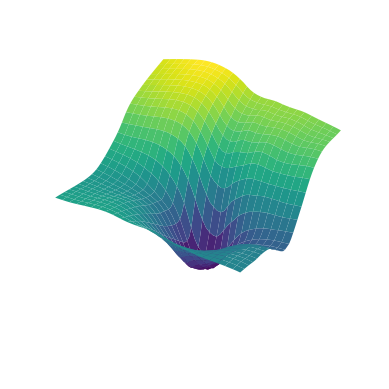

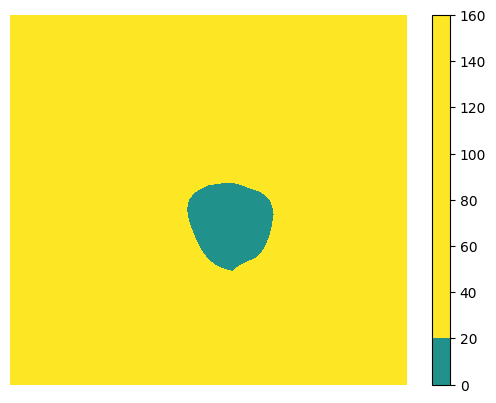

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from pyhessian import hessian # Hessian computation

def get_params(model_orig, direction1, direction2, alpha1, alpha2):
    model_perb = LeNet5_Lorentz() 
    model_perb.load_state_dict(model_orig.state_dict())  
    model_perb = model_perb.cuda()  
    for m_orig, m_perb, d1, d2 in zip(model_orig.parameters(), model_perb.parameters(), direction1, direction2):
        m_perb.data = m_orig.data + alpha1 * d1 + alpha2 * d2
    return model_perb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Different training methods
# PATH = './Training results/01-Standard BP-lambda.pth'  
# PATH = './Training results/02-Standard NJ-lambda.pth' 
# PATH = './Training results/03-Pruning-lambda.pth' 
# PATH = './Training results/04-SAT-lambda.pth' 
PATH = './Training results/05-PAT-lambda.pth'

# Sensitivity analysis
# PATH = './Sensitivity analysis/SAT-rho-1E-32.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E-4.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E-3.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E-2.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E-1.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E0.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E1.pth'
# PATH = './Sensitivity analysis/SAT-rho-1E2.pth'

net = LeNet5()
net.load_state_dict(torch.load(PATH))
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.load_state_dict(torch.load(PATH))

net_Lorentz.conv1.weight.data = lorentzian_inv(net.conv1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.conv2.weight.data = lorentzian_inv(net.conv2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc1.weight.data = lorentzian_inv(net.fc1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc2.weight.data = lorentzian_inv(net.fc2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc3.weight.data = lorentzian_inv(net.fc3.weight.data, A=1, x0=0, gamma=0.15)

lams = np.linspace(-10, 10, 51).astype(np.float32)
loss_matrix = np.zeros((len(lams), len(lams)))

net_Lorentz.eval()

criterion = torch.nn.CrossEntropyLoss()

n = 15
dataiter = iter(testloader)
for _ in range(n - 1):
    next(dataiter)  
n_batch = next(dataiter)  
inputs, targets = n_batch[0].to(device), n_batch[1].to(device)

inputs, targets = inputs.cuda(), targets.cuda()
net_Lorentz.to(device)
# create the hessian computation module
hessian_comp = hessian(net_Lorentz, criterion, data=(inputs, targets), cuda=True)
# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

for i, alpha1 in enumerate(lams):
    for j, alpha2 in enumerate(lams):
        net_Lorentz_perb = get_params(net_Lorentz, top_eigenvector[0],top_eigenvector[1], alpha1, alpha2) 
        loss = criterion(net_Lorentz_perb(inputs), targets).item() 
        loss_matrix[i, j] = loss

X, Y = np.meshgrid(lams, lams)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
ax.plot_surface(X, Y, loss_matrix, cmap='viridis')
ax.set_xlabel('Perturbation in direction 1')
ax.set_ylabel('Perturbation in direction 2')
ax.set_zlabel('Loss')
plt.show()

plt.contourf(X, Y, loss_matrix, vmin=0,vmax=20,cmap='viridis')
plt.colorbar()
plt.xlabel('Perturbation in direction 1')
plt.ylabel('Perturbation in direction 2')
# plt.title('Loss landscape perturbed based on two random directions')
plt.axis('off')
plt.show()

In [ ]:
# BP 745.5
# NJ 414.6
# Pruning 43.0
# SAT 1.05